
# Introduction: Alzheimer_classification Kaggle problem
 ***This is the code based on youtube tutorial: [Deep Learning with PyTorch: Zero to GANs](https://www.youtube.com/watch?v=d9QHNkD_Pos&list=PLCHu_nIKtwrQLzC8ywaXExdtYSkjOKwxg&index=6&t=5293s)*** \

In the above tutorial [Aakash Rao N S]https://jovian.ai/aakashns) applied his code for the [CIFAR10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). 

With this project, I do the imgage classification with a [Kaggle MRI with 4 classes data set](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)

http://www.oasis-brains.org/

NOTE that Aakash does not do the image transformation with his tutorial, tt.Compose. 

I here, I would like to test the testing accuracy using **Resnet34**, when
- Doing no image transformation
- Doing image transformation using torchvision.transforms
- Doing image transformation using monai.transform

## About Dataset
The data consists of MRI images. The data has four classes (from most healthy to leas healthy) of images both in training as well as a testing set:

NOD: Non Demented \
VMD: Very Mild Demented \
MID: Mild Demented \
MOD: Moderate Demented 

Reference: \

In [1]:
import os
import torch
import torchvision
# from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2
import torchvision.transforms as tt


In [2]:
from mymodule import *

# Introduction

This section will explore the `org_dat` folder containing `train` and `test` folders downloaded from [Kaggle](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images). 

We will split the `train` set into `train_ds` (training data set) and `val_ds` (validation data set), do the training and validation step on those data sets, then evaluate model accuracy on the `test_ds` (testing data set). 

We will see that the accuracy on the test_ds is much smaller than on the val_ds. The reason will be explained at the end of this file. Then the next sections will present other approaches to increase the testing accuracy.

# S1. Explore the data

Get the subfolder and classes: the `org_dat` (the original data downloaded from [Kaggle](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)) contains train and test folder. Each folder contains for classes (MildDemented, ModerateDemented, NonDemented, VeryMildDemented)

In [3]:
data_dir = './Data/org_dat/'
subfolders = os.listdir(data_dir) # list the subfolder in the main folder 
print("Subfolder in the data folder: ", subfolders) 
classes = os.listdir(data_dir + "/" + subfolders[1]) # get the class from the train folder 
print("The classes available in each subfolder:", classes)

Subfolder in the data folder:  ['test', 'train']
The classes available in each subfolder: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Get the number of images in each subfolder:

In [4]:
df = num_files_f(data_dir)
print(df)

      MildDemented ModerateDemented NonDemented VeryMildDemented
test           179               12         640              448
train          717               52        2560             1792


Check the images' sizes: We will use the `find_min_max_image_size` function imported from `mymodulo.py` to find the min and max image sizes. We see below that min==max, which means all images in the folder `./data/org_dat/train/VeryMildDemented` have the same size. Similarly for other folders.

In [5]:
find_min_max_img_size(data_img_dir="./data/org_dat/train/VeryMildDemented/*.jpg")

((208, 176, 3), (208, 176, 3))

Load the data as a Pytorch tensors (with NO image transformation)

In [6]:
trainset = ImageFolder(data_dir+'train', transform=ToTensor())
print(len(trainset)), print(trainset.classes)
testset = ImageFolder(data_dir+'test', transform=ToTensor())
print(len(testset)), print(testset.classes)

5121
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
1279
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


(None, None)

Label:  MildDemented (0)


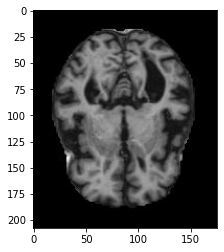

In [7]:
show_example(trainset, 0)

Label:  MildDemented (0)


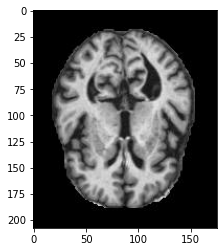

In [8]:
show_example(trainset,80)

Label:  MildDemented (0)


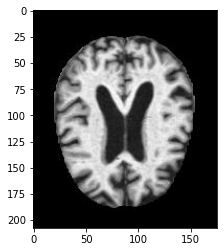

In [9]:
show_example(testset, 0)

Label:  VeryMildDemented (3)


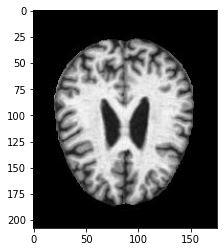

In [10]:
show_example(testset, 1278)

Split into train + val + test

In [7]:
random_seed = 42
torch.manual_seed(random_seed)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


In [8]:
print(len(trainset))
print(len(valset))
print(len(testset))

4096
1025
1279


Create data loader

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32 # start with a smaller number, like, 16, 32, then keep doubling the batchs_ize, and check the training time
#
train_dl = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valset, 
                    batch_size*2, #the valid-batch_size = 2*training-batch_size since we dont need to compute the gradient
                    num_workers=4, pin_memory=True)

Draw a batch 

tensor([3, 2, 0, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2,
        3, 2, 2, 3, 2, 3, 3, 3])


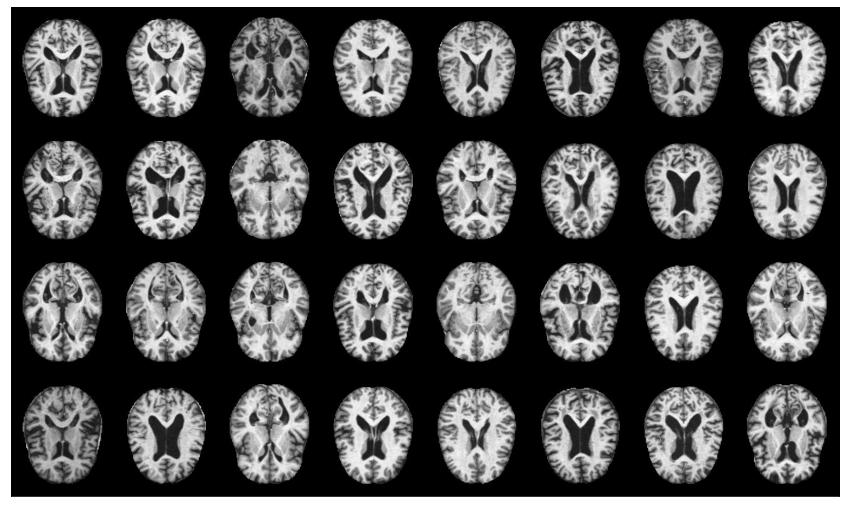

In [10]:
show_batch(train_dl)

tensor([3, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3,
        3, 2, 3, 3, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 3, 0, 3, 2, 2, 3,
        0, 0, 2, 2, 0, 2, 3, 2, 3, 0, 3, 2, 1, 3, 2, 2])


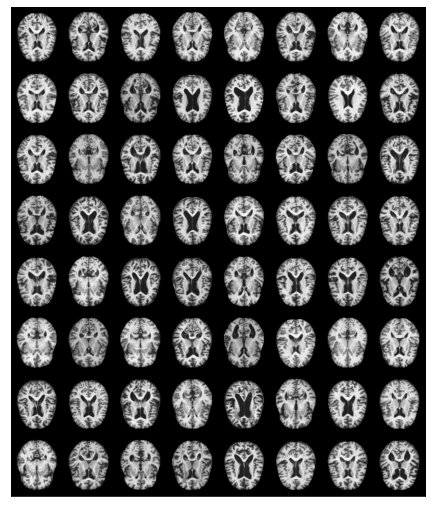

In [11]:
show_batch(val_dl)

# S2 Define model

We will use [Resnet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html) model

In [14]:
from torchvision import models

class Resnet34_No_Transform_model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    

In [16]:
# Run model with GPU 
device = get_default_device()
device

device(type='cuda')

Create train and validation data loaders. Put them to GPU

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# S3. Train Model

In [22]:
model = Resnet34_No_Transform_model(len(classes), pretrained=False)
to_device(model, device);
model

Resnet34_No_Transform_model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [23]:
%%time
epochs = 70
lr = 0.001
opt_func = torch.optim.Adam
history = fit(epochs, lr , model, train_dl, val_dl, opt_func=opt_func)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9458, val_loss: 0.8874, val_acc: 0.6268


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7453, val_loss: 0.8054, val_acc: 0.6553


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5793, val_loss: 1.7277, val_acc: 0.5726


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4004, val_loss: 0.5585, val_acc: 0.7877


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2716, val_loss: 1.2284, val_acc: 0.6259


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1525, val_loss: 0.3951, val_acc: 0.8631


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1271, val_loss: 0.3213, val_acc: 0.8860


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0747, val_loss: 0.1861, val_acc: 0.9347


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0644, val_loss: 0.3189, val_acc: 0.8915


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0556, val_loss: 0.3241, val_acc: 0.8915


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0826, val_loss: 0.1720, val_acc: 0.9485


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0503, val_loss: 0.8443, val_acc: 0.7509


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0413, val_loss: 1.1765, val_acc: 0.6673


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0498, val_loss: 0.0639, val_acc: 0.9835


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0275, val_loss: 0.1016, val_acc: 0.9651


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.0378, val_loss: 0.1018, val_acc: 0.9706


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.0336, val_loss: 0.1678, val_acc: 0.9485


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.0469, val_loss: 0.1644, val_acc: 0.9669


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.0324, val_loss: 0.1659, val_acc: 0.9513


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0489, val_loss: 0.1555, val_acc: 0.9540


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0589, val_loss: 0.1593, val_acc: 0.9660


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0132, val_loss: 0.0679, val_acc: 0.9825


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0090, val_loss: 1.1664, val_acc: 0.6820


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0330, val_loss: 0.1454, val_acc: 0.9605


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0577, val_loss: 0.1478, val_acc: 0.9550


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0167, val_loss: 0.1036, val_acc: 0.9697


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0085, val_loss: 0.0792, val_acc: 0.9779


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0012, val_loss: 0.0671, val_acc: 0.9844


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0004, val_loss: 0.0738, val_acc: 0.9853


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0003, val_loss: 0.0581, val_acc: 0.9853


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0010, val_loss: 0.0761, val_acc: 0.9816


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0775, val_loss: 0.1997, val_acc: 0.9329


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0508, val_loss: 0.1561, val_acc: 0.9540


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0312, val_loss: 0.1958, val_acc: 0.9550


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0262, val_loss: 0.0650, val_acc: 0.9706


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0239, val_loss: 0.1820, val_acc: 0.9504


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0242, val_loss: 0.1673, val_acc: 0.9485


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0368, val_loss: 0.1242, val_acc: 0.9706


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0154, val_loss: 0.1051, val_acc: 0.9743


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0046, val_loss: 0.0961, val_acc: 0.9844


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0013, val_loss: 0.0499, val_acc: 0.9908


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0004, val_loss: 0.0401, val_acc: 0.9908


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0004, val_loss: 0.0686, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0002, val_loss: 0.0738, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0001, val_loss: 0.0616, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0001, val_loss: 0.0576, val_acc: 0.9908


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0001, val_loss: 0.0584, val_acc: 0.9908


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0000, val_loss: 0.0591, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0000, val_loss: 0.0599, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0000, val_loss: 0.0621, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0000, val_loss: 0.0555, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.0000, val_loss: 0.0591, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.0000, val_loss: 0.0647, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0000, val_loss: 0.0603, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0000, val_loss: 0.0605, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0000, val_loss: 0.0591, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0000, val_loss: 0.0579, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0000, val_loss: 0.0631, val_acc: 0.9881


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0000, val_loss: 0.0618, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0000, val_loss: 0.0548, val_acc: 0.9917


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.0000, val_loss: 0.0587, val_acc: 0.9871


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.0000, val_loss: 0.0603, val_acc: 0.9881


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.0000, val_loss: 0.0621, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.0000, val_loss: 0.0617, val_acc: 0.9871


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.0000, val_loss: 0.0593, val_acc: 0.9881


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.0000, val_loss: 0.0622, val_acc: 0.9871


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.0000, val_loss: 0.0605, val_acc: 0.9881


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.0000, val_loss: 0.0583, val_acc: 0.9890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.0000, val_loss: 0.0571, val_acc: 0.9899


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.0000, val_loss: 0.0604, val_acc: 0.9881
CPU times: total: 6min 3s
Wall time: 21min 44s


# S4. Plot train+validation history

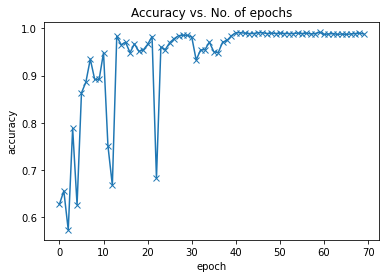

In [30]:
plot_accuracies(history)

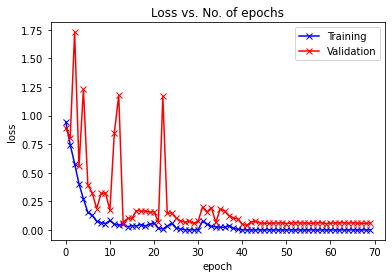

In [31]:
plot_losses(history)

# S5. Save model


In [33]:
torch.save(model.state_dict(), './model/R01_Resnet34_cnn.pth')

# S6 Prediction Testing_Accuracy

In [18]:
R01_Resnet34_cnn = to_device(Resnet34_No_Transform_model(4), device)  #  redefine the model with the same structure of the MRIModel
R01_Resnet34_cnn.load_state_dict(torch.load('./model/R01_Resnet34_cnn.pth'))

<All keys matched successfully>

In [19]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [46]:
def predict_image(img, model, dataset, device):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: MildDemented , Predicted: NonDemented


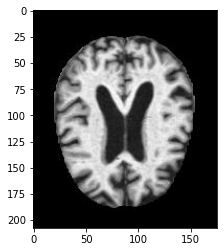

In [20]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testset.classes[label], ', Predicted:', predict_image(img, R01_Resnet34_cnn, testset, device))

In [21]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(R01_Resnet34_cnn, test_loader)
result

{'val_loss': 2.7796249389648438, 'val_acc': 0.6848214268684387}

Create confusion matrix

In [22]:
t = []
p = []
for index in range(len(testset)):
	img, label = testset[index]
	t.append(testset.classes[label])
	p.append(predict_image(img, R01_Resnet34_cnn, testset, device))

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
matrix = confusion_matrix(t,p, labels=testset.classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = testset.classes)


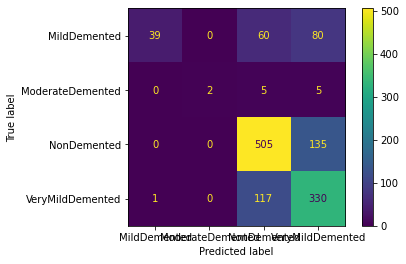

In [25]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

# Why the testing accuracy is so low comparing to validation accuracy?

Here is my thought about the reason for low testing accuracy and some approaches I will use to improve testing accuracy. 

## Reason and approach 1
***Reason 1***: The first reason I can explain for low testing accuracy that I first think about is that the **test set is so different from the train and validation sets**. This is why:
- First, the way the test images are named is different from the way the ones in the training set are named. \
- Second, Look at the testing and training images; the testing set seems to include images taken from different layers of brains compared to the training set. 

Let's make the reasoning concrete by considering a batch of validation and testing sets and images of layers of a brain.

tensor([3, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3,
        3, 2, 3, 3, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 3, 0, 3, 2, 2, 3,
        0, 0, 2, 2, 0, 2, 3, 2, 3, 0, 3, 2, 1, 3, 2, 2])


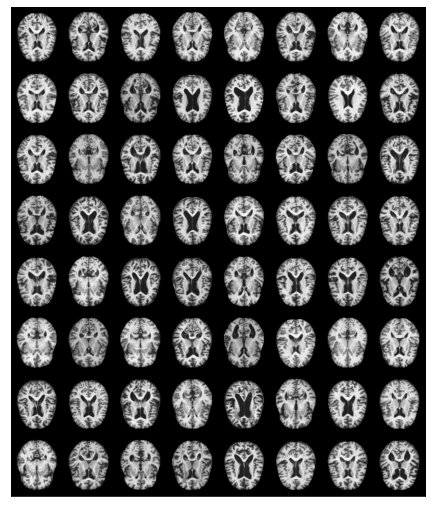

In [26]:
show_batch(val_dl)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


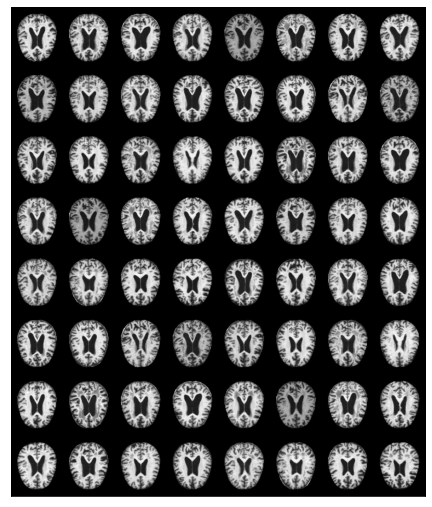

In [29]:
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())
test_dl = DataLoader(test_ds, batch_size*2)
show_batch(test_dl)

Layers of a brain:

 ![Layers of a brain. Source: http://cs.wellesley.edu/~cs112/courseMaterials/assignments/assign5/assign5.html](http://cs.wellesley.edu/~cs112/courseMaterials/assignments/assign5/slices.jpg)

I feel convinced looking those pics. Don't you?

**Approach 1**: Mix the data. Then split them into three new train, validation, and testing sets. It is quite a naive approach, and I know we never should do that. But I could not find any information about the data source, and I want to see if I could improve the testing accuracy if I do this. And yes, in the next section, I see that the testing accuracy is 99%.

## Reason and approach 2
**Reason 2**: same as reason 1.

**Approach 2**:Learn about [Image registration](https://en.wikipedia.org/wiki/Image_registration) to see if I can do anything with it. I have not know about Image registration but I have found some sources that I can learn it.

## Reason and approach 3
**Reason 3**: same as reason 1 and 2 😆 .

**Approach 3**: Using Bayesian CNN. (will do ❤️‍🔥)